# Scenario 2: Popularity-Based (Global Top Charts)

This notebook implements a **Popularity-Based** recommendation system, often used as a baseline or for new users.

## Concept
Popularity-based systems recommend items that are globally liked by the majority of users.

### Key Metrics:
1. **Average Rating**: The mean score given by all users.
2. **Rating Count**: The total number of times a movie has been rated (indicates visibility).
3. **Weighted Score (IMDb Formula)**: A combination of average rating and count to ensure that a movie with one 5-star rating doesn't outrank a movie with thousands of 4.8-star ratings.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')

print(f"Loaded {len(movies)} movies and {len(ratings)} ratings.")

Loaded 9742 movies and 100836 ratings.


## 1. Calculating Basic Statistics
We calculate the mean rating and the number of ratings for each movie.

In [2]:
# Group by movieId and calculate statistics
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['mean', 'count']
})

# Flatten columns
movie_stats.columns = ['avg_rating', 'rating_count']

# Merge with movie titles
movie_popularity = movie_stats.merge(movies, on='movieId')

movie_popularity.head()

,movieId,avg_rating,rating_count,title,genres
0,1,3.920930,215,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,3.431818,110,Jumanji (1995),Adventure|Children|Fantasy
2,3,3.259615,52,Grumpier Old Men (1995),Comedy|Romance
3,4,2.357143,7,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,3.071429,49,Father of the Bride Part II (1995),Comedy


## 2. Weighted Rating (IMDb Style)
To avoid bias from movies with very few ratings, we use a weighted rating formula:

$$WR = (\frac{v}{v+m} \cdot R) + (\frac{m}{v+m} \cdot C)$$

Where:
- $v$ is the number of ratings for the movie
- $m$ is the minimum ratings required to be listed (e.g., 90th percentile)
- $R$ is the average rating of the movie
- $C$ is the mean rating across the whole report

In [3]:
C = movie_popularity['avg_rating'].mean()
m = movie_popularity['rating_count'].quantile(0.90)

print(f"Global Average Rating (C): {C:.2f}")
print(f"Minimum Ratings Required (m): {m}")

def weighted_rating(x, m=m, C=C):
    v = x['rating_count']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

# Apply the formula
movie_popularity['weighted_score'] = movie_popularity.apply(weighted_rating, axis=1)

# Get top 10 movies
top_charts = movie_popularity.sort_values('weighted_score', ascending=False)

print("\nTop 10 Movies (Weighted Score):")
top_charts[['title', 'rating_count', 'avg_rating', 'weighted_score']].head(10)

Global Average Rating (C): 3.26
Minimum Ratings Required (m): 27.0

Top 10 Movies (Weighted Score):


,title,rating_count,avg_rating,weighted_score
277,"Shawshank Redemption, The (1994)",317,4.429022,4.337460
659,"Godfather, The (1972)",192,4.289062,4.162494
2224,Fight Club (1999),218,4.272936,4.161576
224,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.137000
46,"Usual Suspects, The (1995)",204,4.237745,4.123749
257,Pulp Fiction (1994),307,4.197068,4.121515
461,Schindler's List (1993),220,4.225000,4.119782
1938,"Matrix, The (1999)",278,4.192446,4.110118
897,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.107505
314,Forrest Gump (1994),329,4.164134,4.095747


## 3. Visualizing Trends
Let's visualize the relationship between rating count and average rating.

<Figure size 1000x800 with 0 Axes>

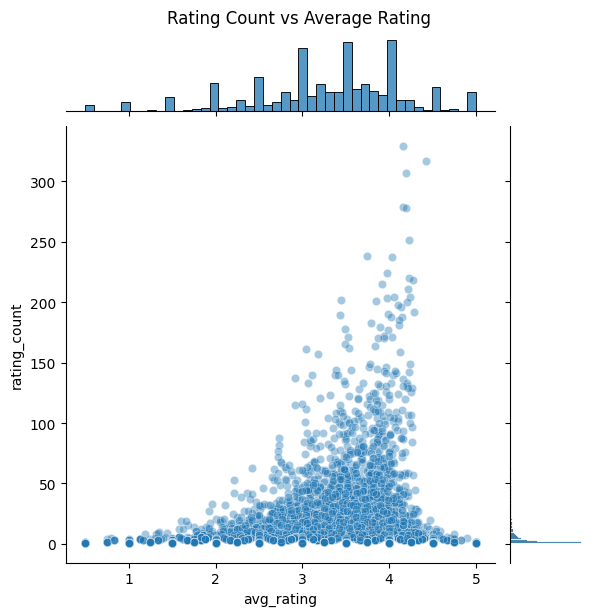

In [9]:
plt.figure(figsize=(10, 8))
sns.jointplot(x='avg_rating', y='rating_count', data=movie_popularity, alpha=0.4)
plt.suptitle('Rating Count vs Average Rating', y=1.02)
plt.show()

## 4. Genre-Specific Popularity
Users often want to see the top charts for a specific genre.

In [11]:
def get_genre_top_charts(genre, n=10):
    genre_movies = movie_popularity[movie_popularity['genres'].str.contains(genre, case=False)]
    return genre_movies.sort_values('weighted_score', ascending=False).head(n)


In [12]:
print("Top Action Movies:")
get_genre_top_charts('Action')[['title', 'weighted_score']]

Top Action Movies:


,title,weighted_score
2224,Fight Club (1999),4.161576
224,Star Wars: Episode IV - A New Hope (1977),4.137000
1938,"Matrix, The (1999)",4.110118
897,Star Wars: Episode V - The Empire Strikes Back...,4.107505
899,Raiders of the Lost Ark (Indiana Jones and the...,4.095093
6693,"Dark Knight, The (2008)",4.088557
898,"Princess Bride, The (1987)",4.077433
1502,Saving Private Ryan (1998),4.035284
910,Star Wars: Episode VI - Return of the Jedi (1983),4.031776
908,Apocalypse Now (1979),4.026762
